<a href="https://colab.research.google.com/github/xuziyue/tensorflow-models/blob/main/flowers_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [6]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [7]:
feature_extractor = hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [8]:
# dataset = tf.data.Dataset.range(8)
# dataset = dataset.shuffle(4).batch(2)
# dataset = dataset.prefetch(2)
# list(dataset.as_numpy_iterator())

In [9]:
feature_extractor.trainable = False

In [10]:
model = tf.keras.Sequential([feature_extractor,
                             layers.Dense(num_classes)])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
EPOCHS = 6
history = model.fit(train_batches,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    steps_per_epoch=int(np.ceil(num_training_examples / float(BATCH_SIZE))),
                    validation_steps=int(np.ceil(num_validation_examples / float(BATCH_SIZE))))

Epoch 1/6
81/81 [==============================] - 37s 61ms/step - loss: 0.7510 - accuracy: 0.7252 - val_loss: 0.4377 - val_accuracy: 0.8583
Epoch 2/6
81/81 [==============================] - 4s 49ms/step - loss: 0.3713 - accuracy: 0.8758 - val_loss: 0.3660 - val_accuracy: 0.8774
Epoch 3/6
81/81 [==============================] - 4s 49ms/step - loss: 0.2979 - accuracy: 0.9031 - val_loss: 0.3244 - val_accuracy: 0.8828
Epoch 4/6
81/81 [==============================] - 4s 49ms/step - loss: 0.2479 - accuracy: 0.9253 - val_loss: 0.3144 - val_accuracy: 0.8992
Epoch 5/6
81/81 [==============================] - 4s 50ms/step - loss: 0.2116 - accuracy: 0.9401 - val_loss: 0.3046 - val_accuracy: 0.9046
Epoch 6/6
81/81 [==============================] - 4s 49ms/step - loss: 0.1881 - accuracy: 0.9482 - val_loss: 0.3023 - val_accuracy: 0.8883


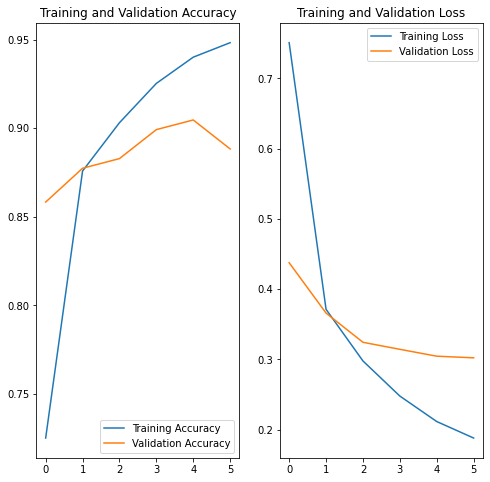

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
class_names = np.array(dataset_info.features['label'].names)

In [16]:
image_batch, label_batch = next(train_batches.as_numpy_iterator())

In [17]:
predicted_batch = model.predict(image_batch)

In [18]:
predicted_batch = tf.squeeze(predicted_batch).numpy()

In [19]:
predicted_ids = np.argmax(predicted_batch, axis=-1)

In [20]:
predicted_class_names = class_names[predicted_ids]

Text(0.5, 0.98, 'Model predictions (blue: correct, red: incorrect)')

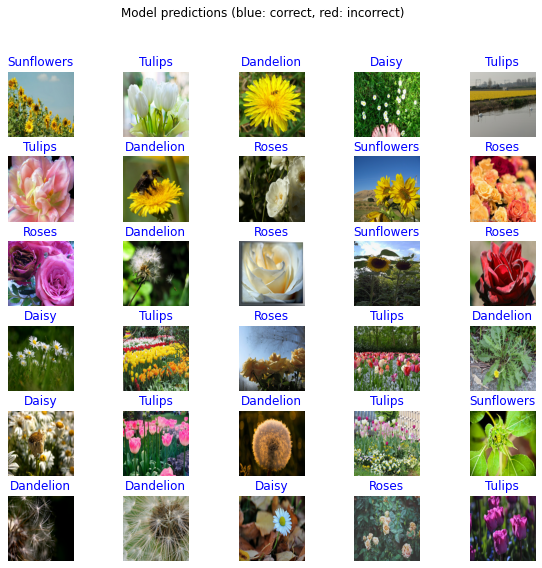

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [24]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

feature_extractor = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4", input_shape=(IMAGE_RES, IMAGE_RES, 3))

feature_extractor.trainable = False

model = tf.keras.Sequential([feature_extractor, layers.Dense(num_classes)])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
EPOCHS = 6
history_2 = model.fit(train_batches,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=validation_batches,
                      steps_per_epoch=int(np.ceil(num_training_examples / float(BATCH_SIZE))),
                      validation_steps=int(np.ceil(num_validation_examples / float(BATCH_SIZE))))

Epoch 1/6
81/81 [==============================] - 75s 167ms/step - loss: 0.7737 - accuracy: 0.7186 - val_loss: 0.4576 - val_accuracy: 0.8565
Epoch 2/6
81/81 [==============================] - 13s 161ms/step - loss: 0.3899 - accuracy: 0.8797 - val_loss: 0.3611 - val_accuracy: 0.8883
Epoch 3/6
81/81 [==============================] - 14s 177ms/step - loss: 0.3132 - accuracy: 0.9019 - val_loss: 0.3328 - val_accuracy: 0.8883
Epoch 4/6
81/81 [==============================] - 13s 162ms/step - loss: 0.2666 - accuracy: 0.9163 - val_loss: 0.3138 - val_accuracy: 0.9001
Epoch 5/6
81/81 [==============================] - 13s 163ms/step - loss: 0.2376 - accuracy: 0.9315 - val_loss: 0.2899 - val_accuracy: 0.9028
Epoch 6/6
81/81 [==============================] - 13s 165ms/step - loss: 0.2037 - accuracy: 0.9389 - val_loss: 0.2787 - val_accuracy: 0.9037
